In [1]:
import re
import os
import torch
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import T5TokenizerFast, T5ForConditionalGeneration
from tqdm.notebook import tqdm
from collections import Counter
from torch import nn
from catalyst import dl
from langdetect import detect

DOCS_DIR = 'wiki_data_old/downloaded_data/documents_new'
PAGES_DIR = 'wiki_data_old/downloaded_data/revision_new'

In [2]:
torch.__version__

'1.10.1+cu102'

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
    pass
    
CONFIG = Config()
CONFIG.seed = 1337
CONFIG.src_max_len = 900
CONFIG.tgt_max_len = 900
CONFIG.pretrained = 't5-small'
CONFIG.batch_size = 8

In [4]:
dataset_ids = list(map(lambda x: int(x.split('.')[0]), os.listdir(DOCS_DIR)))
dataset_ids[:5]

[8766, 3571, 7671, 3463, 6720]

In [5]:
db_dict = {'obj_id': [], 'old_text': [], 'new_text': [], 'comment': [], 'docs': [], 'diff': []}
for dataset_obj_id in tqdm(dataset_ids):
    with open(f"{PAGES_DIR}/{dataset_obj_id}.json", 'r', encoding='utf-8') as f:
        page_json = json.load(f)
    docs_text = ''
    added_docs = set()
    count_docs = 0
    with open(f"{DOCS_DIR}/{dataset_obj_id}.txt", 'r', encoding='utf-8') as f:
        docs_text_plain = f.read()
        docs = docs_text_plain.split('\n\nDOC_DELIMITER_TOKEN\n\n')
        for doc_id, doc in enumerate(docs):
            if doc not in added_docs:
                added_docs.add(doc)
                count_docs += 1
                docs_text += f" DOC{count_docs}: {doc}"
            if count_docs > 2:
                break

    if count_docs < 3:
        continue
    if 'link' in db_dict['comment'] or 'ref' in db_dict['comment']:
        continue
    try:
        text_lang = detect(page_json['old_text'])
        comment_lang = detect(page_json['comment'])
    except:
        text_lang = ''
        comment_lang = ''

    if text_lang == 'en':
        diff = '\n'.join(page_json['change_texts'][0][0])
        db_dict['diff'].append(diff)
        db_dict['obj_id'].append(dataset_obj_id)
        db_dict['old_text'].append(page_json['old_text'])
        db_dict['new_text'].append(page_json['new_text'])
        db_dict['comment'].append('Comment: ' + page_json['comment'])
        db_dict['docs'].append(docs_text.strip())

In [6]:
df = pd.DataFrame.from_dict(db_dict)
print(df.shape)

(8700, 6)


In [7]:
import random

random.seed(CONFIG.seed)
os.environ['PYTHONHASHSEED'] = str(CONFIG.seed)
np.random.seed(CONFIG.seed)
torch.manual_seed(CONFIG.seed)
torch.cuda.manual_seed(CONFIG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [8]:
test_idxs = np.random.choice(df.shape[0], 103)
all_idxs = np.arange(df.shape[0])
other_idxs = np.setdiff1d(all_idxs, test_idxs)

In [9]:
df_test = df.iloc[test_idxs]
df = df.iloc[other_idxs]

In [10]:
df.head()

,obj_id,old_text,new_text,comment,docs,diff
0,8766,Andronicus of Cyrrhus was a Greek astronomer w...,Andronicus of Cyrrhus was a Greek astronomer w...,Comment: [[sl:Andronik]],DOC1: Andronicus of Cyrrhus or Andronicus Cyrr...,\n\n\n\nsl:Andronik
1,6720,*Much of the material in these articles comes ...,*Much of the material in these articles comes ...,Comment: =External links=,DOC1: Costa Rica (UK: / ˌ k ɒ s t ə ˈ r iː k ə...,\nde:Costa Rica et:Costa Rica
2,1870,"Christian Goldbach (1690 - 1764), was a Prussi...","Christian Goldbach (March 18,1690 - November 2...",Comment: Added dates of birth and death,"DOC1: Christian Goldbach, (born March 18, 1690...","March 18,\nNovember 20,"
3,9051,* African Studies Association of the United Ki...,* African Studies Association of the United Ki...,Comment: /* Education */ added Alandica Shippi...,DOC1: Alandica Shipping Academy: Maritime educ...,"Alandica Shipping Academy, Åland Islands, Finl..."
4,5712,* online and downloadable Bambara-French Dicti...,* online and downloadable Bambara-French Dicti...,Comment: /* Dictionaries */ Added an additiona...,DOC1: $20.87 5 New from $20.87 This book is in...,Mobile friendly Bambara-English dictionary. Ad...


In [11]:
def get_tgt(row, text_to_lower=True, comment_to_lower=True, comment_delimiter=' TEXT '):
    new_text = row.new_text.lower() if text_to_lower else row.new_text
    coms = row.comment.lower() if comment_to_lower else row.comment
    tgt = coms + comment_delimiter + new_text
    return tgt

def get_src(row, text_to_lower=True, comment_to_lower=True, doc_delimiter=' DOCS '):
    old_text = row.old_text.lower() if text_to_lower else row.old_text 
    docs = row.docs.lower() if text_to_lower else row.docs 
    src = 'TEXT ' + old_text + doc_delimiter + docs
    return src
    
class EditDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: list, tokenizer, config,
                 text_to_lower=True, comment_to_lower=True):
        self.db = dataset
        self.tokenizer = tokenizer

        
        src_text = self.db.apply(lambda x: get_src(x, text_to_lower, comment_to_lower), axis=1).values
        tgt_text = self.db.apply(lambda x: get_tgt(x, text_to_lower, comment_to_lower), axis=1).values
        
        self.src_text_tokenized = [tokenizer(x,
                                       max_length=config.src_max_len,
                                       truncation=True,
                                       return_attention_mask=False,
                                       ) for x in src_text]
        self.tgt_text_tokenized = [tokenizer(x,
                                       max_length=config.tgt_max_len,
                                       truncation=True,
                                       return_attention_mask=False,
                                       ) for x in tgt_text]

    def __len__(self):
        return len(self.db)

    def __getitem__(self, idx: int):
        src = self.src_text_tokenized[idx]
        tgt = self.tgt_text_tokenized[idx]
        return src, tgt

    @staticmethod
    def collate_fn(samples, tokenizer, config):
        src_samples = [x[0] for x in samples]
        tgt_samples = [x[1] for x in samples]

        src_samples = tokenizer.pad(src_samples,
                                    padding='longest',
                                    max_length=config.final_src_max_len,
                                    return_attention_mask=False,
                                    return_tensors='pt')['input_ids']

        tgt_samples = tokenizer.pad(tgt_samples,
                                    padding='longest',
                                    max_length=config.final_tgt_max_len,
                                    return_attention_mask=False,
                                    return_tensors='pt')['input_ids']

        return (src_samples, tgt_samples), torch.ones(len(samples), 1)

In [12]:
tokenizer = T5TokenizerFast.from_pretrained(CONFIG.pretrained, model_max_length=1000)

In [13]:
ds_edit = EditDataset(df, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val = EditDataset(df_test, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)

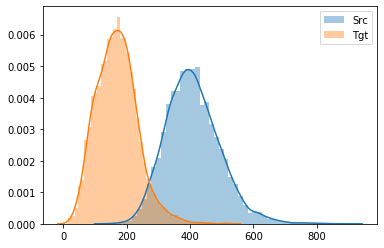

In [14]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_edit:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.distplot(arr_src, label='Src');
plt.legend();
sns.distplot(arr_tgt, label='Tgt');
plt.legend();

## Learning

In [15]:
CONFIG.batch_size = 4
CONFIG.final_src_max_len = 700
CONFIG.final_tgt_max_len = 400
loaders = {
    'train': torch.utils.data.DataLoader(ds_edit, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True),
    'valid': torch.utils.data.DataLoader(ds_val, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True)
}

In [16]:
class EditModel(nn.Module):
    def __init__(self, pretrained, config):
        super(EditModel, self).__init__()
        self.pretrained = pretrained
        

    def forward(self, x):
        src, tgt = x
        
        tgt[tgt == 0] == -100
        
        loss = self.pretrained(
            input_ids = src,
            attention_mask = (src != 0).float(),
            labels=tgt,
        ).loss
        return loss
    
    
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        
    def forward(self, pred, tgt):
        return pred

In [17]:
model = EditModel(
    T5ForConditionalGeneration.from_pretrained(CONFIG.pretrained),
    CONFIG
)
CONFIG.optimizer = 'Adam(lr=0.0001)'
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

CONFIG.name = f'{CONFIG.pretrained}_test_8000objs'
CONFIG.description = f'{CONFIG.name} p(comment, x_t+1 | x_t, doc)'
CONFIG.group = "wiki_edit_test"

In [18]:
!rm -rf ./models/"{CONFIG.description}"

In [19]:
import torch
import catalyst

from catalyst.core import IRunner
from catalyst.metrics._additive import AdditiveMetric
from catalyst.callbacks.metric import BatchMetricCallback, ICallbackBatchMetric


class ExactMatchMetric(ICallbackBatchMetric):
    def __init__(self, topk, compute_on_call=False):
        super().__init__(compute_on_call=compute_on_call, prefix='', suffix='')
        self.metric_name = 'exact_match'
        self.topk = topk
        self.metrics: List[AdditiveMetric] = [
            AdditiveMetric(compute_on_call=compute_on_call) for _ in range(len(self.topk))]

    def reset(self) -> None:
        for metric in self.metrics:
            metric.reset()

    def update(self, values, n_samples):
        for value, metric in zip(values, self.metrics):
            metric.update(value, n_samples)
        return values

    def update_key_value(self, values, n_samples):
        values = self.update(values, n_samples)
        output = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, values)
        }
        return output

    def compute(self):
        means, stds = zip(*(metric.compute() for metric in self.metrics))
        return means, stds

    def compute_key_value(self):
        means, stds = self.compute()
        output_mean = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, means)
        }
        output_std = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}/std": round(value, 6)
            for key, value in zip(self.topk, stds)
        }
        return {**output_mean, **output_std}


class ExactMatchCallback(BatchMetricCallback):

    def __init__(self, beam_size):
        super().__init__(
            metric= ExactMatchMetric((1,beam_size)) if beam_size > 1 else ExactMatchMetric((1,)),
            input_key='features', target_key='targets', log_on_batch=True)
        self.beam_size = beam_size

    def on_batch_end(self, runner: "IRunner") -> None:

        if runner.loader_key == 'train':
            runner.model.train()
        elif runner.loader_key.startswith('valid'):
            runner.model.eval()

            src = runner.batch['features'][0]
            tgt = runner.batch['features'][1]
            max_len = tgt.shape[1]
            with torch.no_grad():
                pred = runner.model.pretrained.generate(src.to(runner.engine.device),
                                                        attention_mask=(src != 0).float().to(runner.engine.device),
                                                        # pad_token_id=tokenizer.pad_token_id,
                                                        # bos_token_id=tokenizer.bos_token_id,
                                                        # eos_token_id=tokenizer.eos_token_id,
                                                        num_beams=self.beam_size,
                                                        num_return_sequences=self.beam_size,
                                                        max_length=max_len
                                                        )

            pred = pred[:,1:]
            pred = pred.view(-1, self.beam_size, pred.shape[1])
            acck = 0
            acc1 = 0
            for i in range(tgt.shape[0]):
                tgt_subseq = tgt[i, :pred.shape[2]].to(runner.engine.device)

                acck += float(torch.any(torch.all(tgt_subseq == pred[i], dim=1)))
                acc1 += float(torch.all(tgt_subseq == pred[i, 0]))

            acck /= len(src)
            acc1 /= len(src)

            metrics = self.metric.update_key_value([acc1, acck], len(src))

            runner.batch_metrics.update(metrics)

    def on_loader_end(self, runner: "IRunner") -> None:
        if runner.loader_key.startswith('valid'):
            metrics = self.metric.compute_key_value()
            metrics = runner.engine.mean_reduce_ddp_metrics(metrics)
            runner.loader_metrics.update(metrics)

In [20]:
CONFIG.n_epochs = 1000
CONFIG.beam_size = 5

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
runner = dl.SupervisedRunner()

# CONFIG.scheduler = 'OneCycleLR(max_lr=0.005, base_momentum=0.85, max_momentum=0.95, div_factor=10.0)'

wandb_logger = dl.WandbLogger(project="interactive_lm", 
                              name=CONFIG.name, 
                              group=CONFIG.group)
# wandb_logger.log_hparams(CONFIG.__dict__)

runner.train(
    loaders=loaders,
    model=model,
    criterion=Criterion(),
    optimizer=optimizer,
#     scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.005, 
#                                                   total_steps=CONFIG.n_epochs*len(loaders_pattern['train']), 
#                                                   base_momentum=0.85, max_momentum=0.95, div_factor=10.0),
    num_epochs=CONFIG.n_epochs,
    callbacks=[
        # dl.EarlyStoppingCallback(loader_key='valid', metric_key='exact_match02', minimize=False, patience=5),
        ExactMatchCallback(beam_size=CONFIG.beam_size),
    ],
    loggers={'wandb': wandb_logger},
    logdir=f'./models/{CONFIG.description}',
    valid_loader='valid',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
#     check=True,
#     cpu=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anton-sh. Use `wandb login --relogin` to force relogin


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (1/1000) loss: 0.6272546833268442 | loss/mean: 0.6272546833268442 | loss/std: 0.38733012801269545 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (1/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.45876882626460147 | loss/mean: 0.45876882626460147 | loss/std: 0.10400519678107419 | lr: 0.0001 | momentum: 0.9
* Epoch (1/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (2/1000) loss: 0.46719434735386883 | loss/mean: 0.46719434735386883 | loss/std: 0.15788139246286462 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (2/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4350523020212467 | loss/mean: 0.4350523020212467 | loss/std: 0.11588442445587019 | lr: 0.0001 | momentum: 0.9
* Epoch (2/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (3/1000) loss: 0.4378365310645385 | loss/mean: 0.4378365310645385 | loss/std: 0.15060667953774268 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (3/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4280292454820413 | loss/mean: 0.4280292454820413 | loss/std: 0.1444781825078894 | lr: 0.0001 | momentum: 0.9
* Epoch (3/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (4/1000) loss: 0.4171472633785985 | loss/mean: 0.4171472633785985 | loss/std: 0.15221851028384262 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (4/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.42538454268987363 | loss/mean: 0.42538454268987363 | loss/std: 0.12645906391816453 | lr: 0.0001 | momentum: 0.9
* Epoch (4/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (5/1000) loss: 0.39919946717661486 | loss/mean: 0.39919946717661486 | loss/std: 0.14472825888604263 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (5/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.42659470037772107 | loss/mean: 0.42659470037772107 | loss/std: 0.1646660473372428 | lr: 0.0001 | momentum: 0.9
* Epoch (5/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (6/1000) loss: 0.38506892451366614 | loss/mean: 0.38506892451366614 | loss/std: 0.14005534562842128 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (6/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.413531034038617 | loss/mean: 0.413531034038617 | loss/std: 0.11081592031862374 | lr: 0.0001 | momentum: 0.9
* Epoch (6/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (7/1000) loss: 0.3726201973197069 | loss/mean: 0.3726201973197069 | loss/std: 0.13596275799967403 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (7/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4068947262488879 | loss/mean: 0.4068947262488879 | loss/std: 0.13639690595502288 | lr: 0.0001 | momentum: 0.9
* Epoch (7/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (8/1000) loss: 0.3616074130666812 | loss/mean: 0.3616074130666812 | loss/std: 0.13209566498170908 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (8/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4183182171904124 | loss/mean: 0.4183182171904124 | loss/std: 0.1495660568938825 | lr: 0.0001 | momentum: 0.9
* Epoch (8/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (9/1000) loss: 0.3518741815554536 | loss/mean: 0.3518741815554536 | loss/std: 0.1311502284913805 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (9/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.41275703219267035 | loss/mean: 0.41275703219267035 | loss/std: 0.11773305164587018 | lr: 0.0001 | momentum: 0.9
* Epoch (9/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (10/1000) loss: 0.3431803250797965 | loss/mean: 0.3431803250797965 | loss/std: 0.12655585320539817 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (10/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4194608737642948 | loss/mean: 0.4194608737642948 | loss/std: 0.14100273306175623 | lr: 0.0001 | momentum: 0.9
* Epoch (10/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (11/1000) loss: 0.33544077492384083 | loss/mean: 0.33544077492384083 | loss/std: 0.12525374083316712 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (11/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4159769129294616 | loss/mean: 0.4159769129294616 | loss/std: 0.14739950771707377 | lr: 0.0001 | momentum: 0.9
* Epoch (11/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (12/1000) loss: 0.3248327711709708 | loss/mean: 0.3248327711709708 | loss/std: 0.11993831306854773 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (12/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.41974436205167037 | loss/mean: 0.41974436205167037 | loss/std: 0.13286240605733382 | lr: 0.0001 | momentum: 0.9
* Epoch (12/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (13/1000) loss: 0.31774214330454226 | loss/mean: 0.31774214330454226 | loss/std: 0.11878816792962377 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (13/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.42678714486268854 | loss/mean: 0.42678714486268854 | loss/std: 0.11724428545127177 | lr: 0.0001 | momentum: 0.9
* Epoch (13/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (14/1000) loss: 0.3115923956140529 | loss/mean: 0.3115923956140529 | loss/std: 0.11984241831701287 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (14/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.43367407700190186 | loss/mean: 0.43367407700190186 | loss/std: 0.12868317199123255 | lr: 0.0001 | momentum: 0.9
* Epoch (14/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (15/1000) loss: 0.3048198278906738 | loss/mean: 0.3048198278906738 | loss/std: 0.11942565437754268 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (15/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4197951377584384 | loss/mean: 0.4197951377584384 | loss/std: 0.1429684158905377 | lr: 0.0001 | momentum: 0.9
* Epoch (15/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (16/1000) loss: 0.2966153215253079 | loss/mean: 0.2966153215253079 | loss/std: 0.11698555176003587 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (16/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4314070395552194 | loss/mean: 0.4314070395552194 | loss/std: 0.15354346472418776 | lr: 0.0001 | momentum: 0.9
* Epoch (16/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (17/1000) loss: 0.2910037736438737 | loss/mean: 0.2910037736438737 | loss/std: 0.11036988410051042 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (17/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.43380710769158143 | loss/mean: 0.43380710769158143 | loss/std: 0.12799677771573045 | lr: 0.0001 | momentum: 0.9
* Epoch (17/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (18/1000) loss: 0.2846307042310409 | loss/mean: 0.2846307042310409 | loss/std: 0.11135421405473216 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (18/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4378103166818619 | loss/mean: 0.4378103166818619 | loss/std: 0.13849040821808706 | lr: 0.0001 | momentum: 0.9
* Epoch (18/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (19/1000) loss: 0.27903399158009234 | loss/mean: 0.27903399158009234 | loss/std: 0.1063916014158719 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (19/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4292023462744859 | loss/mean: 0.4292023462744859 | loss/std: 0.1627992162286429 | lr: 0.0001 | momentum: 0.9
* Epoch (19/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (20/1000) loss: 0.27484805698658143 | loss/mean: 0.27484805698658143 | loss/std: 0.10473795227400917 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (20/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.44099737130678623 | loss/mean: 0.44099737130678623 | loss/std: 0.1361377315450881 | lr: 0.0001 | momentum: 0.9
* Epoch (20/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (21/1000) loss: 0.2682990560490035 | loss/mean: 0.2682990560490035 | loss/std: 0.10507179416333784 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (21/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.45020928635047036 | loss/mean: 0.45020928635047036 | loss/std: 0.1356256538541407 | lr: 0.0001 | momentum: 0.9
* Epoch (21/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (22/1000) loss: 0.26128858959952095 | loss/mean: 0.26128858959952095 | loss/std: 0.10028967898399137 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (22/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.45274004454796135 | loss/mean: 0.45274004454796135 | loss/std: 0.16365171630827302 | lr: 0.0001 | momentum: 0.9
* Epoch (22/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (23/1000) loss: 0.25798802636910345 | loss/mean: 0.25798802636910345 | loss/std: 0.10226714547835042 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (23/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.43916509185846037 | loss/mean: 0.43916509185846037 | loss/std: 0.15744007700903043 | lr: 0.0001 | momentum: 0.9
* Epoch (23/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (24/1000) loss: 0.25472586139343506 | loss/mean: 0.25472586139343506 | loss/std: 0.0986679635290502 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (24/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.45134686392087214 | loss/mean: 0.45134686392087214 | loss/std: 0.16193890291620602 | lr: 0.0001 | momentum: 0.9
* Epoch (24/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (25/1000) loss: 0.24782688867387392 | loss/mean: 0.24782688867387392 | loss/std: 0.09733954475158599 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (25/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.44155612244055825 | loss/mean: 0.44155612244055825 | loss/std: 0.14521676802230754 | lr: 0.0001 | momentum: 0.9
* Epoch (25/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (26/1000) loss: 0.24305079638264893 | loss/mean: 0.24305079638264893 | loss/std: 0.09437277077208221 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (26/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.44662156127966374 | loss/mean: 0.44662156127966374 | loss/std: 0.1599067070090443 | lr: 0.0001 | momentum: 0.9
* Epoch (26/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (27/1000) loss: 0.23992703827141307 | loss/mean: 0.23992703827141307 | loss/std: 0.0950226229894536 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (27/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.44918702657406145 | loss/mean: 0.44918702657406145 | loss/std: 0.1732885694102958 | lr: 0.0001 | momentum: 0.9
* Epoch (27/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (28/1000) loss: 0.23613143570721115 | loss/mean: 0.23613143570721115 | loss/std: 0.09103940744251707 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (28/1000) exact_match01: 0.009709 | exact_match01/std: 0.056328 | exact_match05: 0.009709 | exact_match05/std: 0.056328 | loss: 0.4613822308870463 | loss/mean: 0.4613822308870463 | loss/std: 0.17776494986481325 | lr: 0.0001 | momentum: 0.9
* Epoch (28/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (29/1000) loss: 0.23114201090883382 | loss/mean: 0.23114201090883382 | loss/std: 0.09286329014214062 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (29/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4641212884050148 | loss/mean: 0.4641212884050148 | loss/std: 0.17785651867135435 | lr: 0.0001 | momentum: 0.9
* Epoch (29/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (30/1000) loss: 0.22618882875976143 | loss/mean: 0.22618882875976143 | loss/std: 0.08878420515670886 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (30/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4671943485736847 | loss/mean: 0.4671943485736847 | loss/std: 0.133321284383794 | lr: 0.0001 | momentum: 0.9
* Epoch (30/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (31/1000) loss: 0.22203826452237221 | loss/mean: 0.22203826452237221 | loss/std: 0.08710895726242626 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (31/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.47153030679776126 | loss/mean: 0.47153030679776126 | loss/std: 0.15707022011583105 | lr: 0.0001 | momentum: 0.9
* Epoch (31/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (32/1000) loss: 0.21814328056088736 | loss/mean: 0.21814328056088736 | loss/std: 0.08744783618737234 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (32/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4697353077622561 | loss/mean: 0.4697353077622561 | loss/std: 0.16514550361344785 | lr: 0.0001 | momentum: 0.9
* Epoch (32/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (33/1000) loss: 0.2147219310285048 | loss/mean: 0.2147219310285048 | loss/std: 0.08368463924794818 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (33/1000) exact_match01: 0.009709 | exact_match01/std: 0.056328 | exact_match05: 0.009709 | exact_match05/std: 0.056328 | loss: 0.4656140534923626 | loss/mean: 0.4656140534923626 | loss/std: 0.14662318822785556 | lr: 0.0001 | momentum: 0.9
* Epoch (33/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (34/1000) loss: 0.21099620004552744 | loss/mean: 0.21099620004552744 | loss/std: 0.08256173825480508 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (34/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4604885394756611 | loss/mean: 0.4604885394756611 | loss/std: 0.12030896347901633 | lr: 0.0001 | momentum: 0.9
* Epoch (34/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (35/1000) loss: 0.20683687460110667 | loss/mean: 0.20683687460110667 | loss/std: 0.08166227257092237 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (35/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4794256389141083 | loss/mean: 0.4794256389141083 | loss/std: 0.1591921820164544 | lr: 0.0001 | momentum: 0.9
* Epoch (35/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (36/1000) loss: 0.20316726609891247 | loss/mean: 0.20316726609891247 | loss/std: 0.08038435655397906 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (36/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4901743450990089 | loss/mean: 0.4901743450990089 | loss/std: 0.17503068462047272 | lr: 0.0001 | momentum: 0.9
* Epoch (36/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (37/1000) loss: 0.20092117817769234 | loss/mean: 0.20092117817769234 | loss/std: 0.08099733206492744 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (37/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4969413558451028 | loss/mean: 0.4969413558451028 | loss/std: 0.15271820213419332 | lr: 0.0001 | momentum: 0.9
* Epoch (37/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (38/1000) loss: 0.19560547121908783 | loss/mean: 0.19560547121908783 | loss/std: 0.07717779005029571 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (38/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.49390209695467585 | loss/mean: 0.49390209695467585 | loss/std: 0.18571020294792204 | lr: 0.0001 | momentum: 0.9
* Epoch (38/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (39/1000) loss: 0.1938266395430927 | loss/mean: 0.1938266395430927 | loss/std: 0.07575715658113981 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (39/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4918412067569219 | loss/mean: 0.4918412067569219 | loss/std: 0.16428149608416895 | lr: 0.0001 | momentum: 0.9
* Epoch (39/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (40/1000) loss: 0.19065998138210094 | loss/mean: 0.19065998138210094 | loss/std: 0.07529229819006888 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (40/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4945808757956212 | loss/mean: 0.4945808757956212 | loss/std: 0.15372450364880416 | lr: 0.0001 | momentum: 0.9
* Epoch (40/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (41/1000) loss: 0.18682336346181322 | loss/mean: 0.18682336346181322 | loss/std: 0.07376793712501395 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (41/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4977677114881001 | loss/mean: 0.4977677114881001 | loss/std: 0.17086663759111098 | lr: 0.0001 | momentum: 0.9
* Epoch (41/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (42/1000) loss: 0.18411703341922073 | loss/mean: 0.18411703341922073 | loss/std: 0.07392568052638318 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (42/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.4929545802565722 | loss/mean: 0.4929545802565722 | loss/std: 0.17608258466378718 | lr: 0.0001 | momentum: 0.9
* Epoch (42/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (43/1000) loss: 0.18065363323792502 | loss/mean: 0.18065363323792502 | loss/std: 0.07155997567675612 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (43/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5078935542931923 | loss/mean: 0.5078935542931923 | loss/std: 0.16930872385876167 | lr: 0.0001 | momentum: 0.9
* Epoch (43/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (44/1000) loss: 0.17795316698592728 | loss/mean: 0.17795316698592728 | loss/std: 0.07042466467658204 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (44/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5171257154299663 | loss/mean: 0.5171257154299663 | loss/std: 0.16915918632380722 | lr: 0.0001 | momentum: 0.9
* Epoch (44/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (45/1000) loss: 0.17430071495473373 | loss/mean: 0.17430071495473373 | loss/std: 0.07024448555837426 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (45/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5053676917002752 | loss/mean: 0.5053676917002752 | loss/std: 0.18598618610050882 | lr: 0.0001 | momentum: 0.9
* Epoch (45/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (46/1000) loss: 0.17140133480519734 | loss/mean: 0.17140133480519734 | loss/std: 0.06723268347073574 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (46/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5341316776779983 | loss/mean: 0.5341316776779983 | loss/std: 0.19939755816672503 | lr: 0.0001 | momentum: 0.9
* Epoch (46/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (47/1000) loss: 0.1680593038852824 | loss/mean: 0.1680593038852824 | loss/std: 0.06709320290296952 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (47/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5074080629990652 | loss/mean: 0.5074080629990652 | loss/std: 0.17222200547085195 | lr: 0.0001 | momentum: 0.9
* Epoch (47/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (48/1000) loss: 0.16660511975024986 | loss/mean: 0.16660511975024986 | loss/std: 0.06480882279638263 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (48/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5321246528854737 | loss/mean: 0.5321246528854737 | loss/std: 0.17756137658390297 | lr: 0.0001 | momentum: 0.9
* Epoch (48/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (49/1000) loss: 0.16285168381277879 | loss/mean: 0.16285168381277879 | loss/std: 0.06510879866242424 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (49/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5215727950517949 | loss/mean: 0.5215727950517949 | loss/std: 0.22357615903392009 | lr: 0.0001 | momentum: 0.9
* Epoch (49/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (50/1000) loss: 0.1599937985040417 | loss/mean: 0.1599937985040417 | loss/std: 0.062244521597447554 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (50/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.536930582844294 | loss/mean: 0.536930582844294 | loss/std: 0.16256991690036726 | lr: 0.0001 | momentum: 0.9
* Epoch (50/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (51/1000) loss: 0.15741815848752524 | loss/mean: 0.15741815848752524 | loss/std: 0.06204382862326527 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (51/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5165984728015387 | loss/mean: 0.5165984728015387 | loss/std: 0.1681429809560483 | lr: 0.0001 | momentum: 0.9
* Epoch (51/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



train (52/1000) loss: 0.1541181870723184 | loss/mean: 0.1541181870723184 | loss/std: 0.060375461809522406 | lr: 0.0001 | momentum: 0.9


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



valid (52/1000) exact_match01: 0.009709 | exact_match01/std: 0.048537 | exact_match05: 0.009709 | exact_match05/std: 0.048537 | loss: 0.5342437321176896 | loss/mean: 0.5342437321176896 | loss/std: 0.19655379790110075 | lr: 0.0001 | momentum: 0.9
* Epoch (52/1000) 


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [23]:
device = runner.engine.device
runner.model.eval()
with torch.no_grad():
    for i in [0, 1, 2, 3, 4]:
        src_, tgt_ = ds_edit[i]
        src_inp = torch.tensor(src_['input_ids']).view(1,-1).to(runner.engine.device)
        generated = runner.model.pretrained.generate(src_inp,
                                              attention_mask=(src_inp != 0).float().to(runner.engine.device),
                                            # pad_token_id=tokenizer.pad_token_id,
                                            # bos_token_id=tokenizer.bos_token_id,
                                            # eos_token_id=tokenizer.eos_token_id,
                                              num_beams=CONFIG.beam_size,
                                              num_return_sequences=CONFIG.beam_size,
                                              max_length=1000
        )
        src_text = tokenizer.decode(src_['input_ids'], skip_special_tokens=True)
        tgt_text = tokenizer.decode(tgt_['input_ids'], skip_special_tokens=True)
        print(f'\n\n----------------------------\t QUERY {i}\t ----------------------------\n')
        print(f'Src query:\n {src_text}')
        print(f'\nTgt query:\n {tgt_text}')
        
        print(f'\n\n----------------------------\t GENERATED\t ----------------------------\n')

        for j in range(CONFIG.beam_size):
            to_gen = generated[j]
            gen_text = tokenizer.decode(to_gen, skip_special_tokens=True)
            print(f'{j}:\n{gen_text}\n')
        
        src_text = df.iloc[i]['old_text']
        tgt_text = df.iloc[i]['new_text']
        diff_text = df.iloc[i]['diff']
        print(f'\nX_T:\n{src_text}')
        print(f'\nX_T+1:\n{tgt_text}')
        print(f'\ndiff:\n{diff_text}')



----------------------------	 QUERY 0	 ----------------------------

Src query:
 TEXT andronicus of cyrrhus was a greek astronomer who flourished about 100 bc. he built a horologium at athens, the so-called tower of the winds, a considerable portion of which still exists. it is octagonal, with figures carved on each side, representing the eight principal winds. in antiquity a bronze figure of triton on the summit, with a rod in his hand, turned round by the wind, pointed to the quarter from which it blew. from this model is derived the custom of placing weathercocks on steeples. DOCS doc1: andronicus of cyrrhus or andronicus cyrrhestes ( greek: , andrónikos kyrrhstou ), son of hermias, was a greek astronomer best known as the architect of the horologion at athens called the tower of the winds. [1] andronicus also built a multifaced sundial in the sanctuary of poseidon on the greek island of tinos. doc2: andronicus of cyrrhus, also called andronicus cyrrhestes, (flourished c. 100 bce 



----------------------------	 QUERY 2	 ----------------------------

Src query:
 TEXT christian goldbach (1690 - 1764), was a prussian mathematician, who was born in koenigsberg, prussia as son of a pastor. goldbach studied jura and mathematics. he traveled widely throughout europe and met with many famous mathematicians, such as leibniz, leonhard euler, nicolas i, bernoulli.goldbach went to work at the newly opened st.petersburg academy and became tutor to the later tsar peter ii. goldbach did important work in the mathematical field. he is remembered today for goldbach's conjecture. DOCS doc1: christian goldbach, (born march 18, 1690, königsberg, prussia [now kaliningrad, russia]—died nov. 20, 1764, moscow, russia), russian mathematician whose contributions to number theory include goldbachs conjecture. in 1725 goldbach became professor of mathematics and historian of the imperial academy at st. petersburg. doc2: christian goldbach (/   o l d b  k /; german: [ltbax]; 18 march 1690 



----------------------------	 QUERY 4	 ----------------------------

Src query:
 TEXT * online and downloadable bambara-french dictionary (about 11,500 entries by the end of 2014), with a french-bambara index, linked with the corpus bambara de référence *bambara entries (>2300) in the french wiktionary *bambara-french-english dictionary online and downloadable lexicons for language learners *bambara tree names (scientific name -> common name) DOCS doc1: $20.87 5 new from $20.87 this book is intended to assist french and english speakers who are visiting west african countries where french and bambara, are spoken. bambara is a mande language used in mali, burkina faso and côte divoire, senegal, gambia, guinea, sierra leone and ghana. doc2: the manding (bambara/jula) dictionary at an ka taa launched in 2019 appears to be the most comprehensive online english-bambara dictionary. it is the mastermind of coleman donaldson, a linguist and manding enthusiast who also produces wonderful vide

In [30]:
import difflib
from nltk.tokenize import sent_tokenize
from difflib import Differ 
from wiki_data_old.utils.difflibparser import DifflibParser, DiffCode

In [46]:
def get_diff_num2(prev_sections_texts, new_sections_texts):
    differ_obj = Differ()
    dif_result = list(DifflibParser(prev_sections_texts, new_sections_texts))
    result = []
    result_idxs = []
    old_text, new_text, last_diff_id = [], [], -1000
    for dif_id, dif_line in enumerate(dif_result):
        if np.abs(dif_id - last_diff_id) > 0:
            nl_ = ''
            ol_ = dif_line['line']
            code = dif_line['code']
            if 'newline' in dif_line:
                nl_ = dif_line['newline']
            dif_line_str = f'{ol_}_{nl_}_{code}'
            result.append(dif_line_str)
            result_idxs.append(dif_id)
            last_diff_id = dif_id
    return set(result)

In [53]:
em1, em5, dm1, dm5, total = 0, 0, 0, 0, 0

for i in tqdm(range(len(ds_val)), total=len(ds_val), position=0, leave=True):
    src_, tgt_ = ds_edit[i]
    src_inp = torch.tensor(src_['input_ids']).view(1,-1).to(runner.engine.device)
    generated = runner.model.pretrained.generate(src_inp,
                                              attention_mask=(src_inp != 0).float().to(runner.engine.device),
                                            # pad_token_id=tokenizer.pad_token_id,
                                            # bos_token_id=tokenizer.bos_token_id,
                                            # eos_token_id=tokenizer.eos_token_id,
                                              num_beams=CONFIG.beam_size,
                                              num_return_sequences=CONFIG.beam_size,
                                              max_length=1000
        )
        
    src_text = tokenizer.decode(src_['input_ids'], skip_special_tokens=True).split('TEXT')[1].split('DOCS')[0].strip()
    tgt_text = tokenizer.decode(tgt_['input_ids'], skip_special_tokens=True).split('TEXT')[1].strip()
    
    gen_texts = []
    for j in range(CONFIG.beam_size):
        to_gen = generated[j]
        gen_text = tokenizer.decode(to_gen, skip_special_tokens=True)
        if 'TEXT' in gen_text:
            gen_text = gen_text.split('TEXT')[1].strip()
        gen_texts.append(gen_text)
    
    
    src_sents = sent_tokenize(src_text)
    tgt_sents = sent_tokenize(tgt_text)
    gen_sents = [sent_tokenize(a) for a in gen_texts]
    
    tdiff = get_diff_num2(src_sents, tgt_sents)
    gen_diffs = [get_diff_num2(src_sents, b) for b in gen_sents]
    
    if len(tdiff) == 0:
        continue
    
    marks = [(len(tdiff.intersection(b)) / max(len(tdiff), len(b))) for b in gen_diffs]
    
    if tgt_text == gen_texts[0]:
        em1 += 1
    if tgt_text in gen_texts:
        em5 += 1
        
    dm1 += marks[0]
    dm5 += max(marks)
    total += 1
    

In [52]:
em1, em5, dm1, dm5, total 

(17, 28, 55.88492063492061, 60.71944444444441, 103)

In [54]:
em1 / total, em5 / total, dm1 / total, dm5 / total 

(0.1650485436893204,
 0.27184466019417475,
 0.5425720449992293,
 0.589509169363538)